# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/orpatashnik/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 778 (delta 119), reused 105 (delta 105), pack-reused 618 (from 1)
Receiving objects: 100% (778/778), 193.81 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Updating files: 100% (246/246), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tmfg2qkf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tmfg2qkf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'guy with a mohawk style hair' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}


In [26]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

In [27]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth"
}

In [28]:
import numpy as np, glob

# ✅ Look only in the ffhq directory
dir_files = sorted(glob.glob('global_directions/npy/ffhq/*.npy'))
assert len(dir_files) > 0, "❌ No .npy files found in global_directions/ffhq!"

# Load and stack
raw = [np.load(f) for f in dir_files]
raw = np.stack(raw)
N, *D = raw.shape
flat = raw.reshape(N, -1)

# Gram-Schmidt
def gram_schmidt(vectors, eps=1e-8):
    Q = []
    for v in vectors:
        w = v.copy()
        for q in Q:
            w -= np.dot(w, q) * q
        n = np.linalg.norm(w)
        if n > eps: Q.append(w / n)
    return np.stack(Q)

orth_flat = gram_schmidt(flat)
orth = orth_flat.reshape(raw.shape)

np.savez('orth_dirs.npz', dirs=orth)
print(f"✅ Saved {orth.shape[0]} orthogonal directions to orth_dirs.npz")

✅ Saved 1 orthogonal directions to orth_dirs.npz


In [37]:
if use_seed:
  import torch
  torch.manual_seed(seed)
import importlib
import optimization.run_optimization
importlib.reload(optimization.run_optimization)

from optimization.run_optimization import main
from argparse import Namespace
result = main(Namespace(**args))

Loading ResNet ArcFace


loss: 0.7354;: 100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


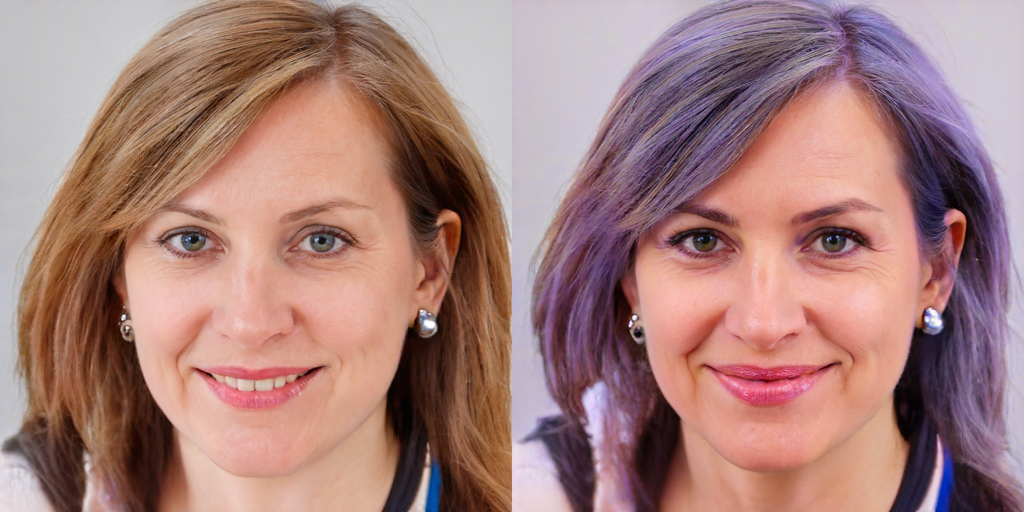

In [38]:
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, value_range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and Download Video

!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')